# Topic modeling using Pandas

Latent Dirichlet Allocation (LDA) is an unsupervised clustering technique that is commonly used for text analysis. Here, words are represented as topics and documents are collection of these word topics.

Use `gensim` module for LDA.

In [ ]:
!pip install -q pyLDAvis pandas==1.5.3

## Import packages

In [ ]:
# gensim packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# nltk packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")

# wordcloud package
from wordcloud import WordCloud

# lda visualization related packages
from IPython.display import display, HTML
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

# other packages
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
# warnings.filterwarnings("ignore", cate)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data
Read data from local directory

In [ ]:
pandasDF = pd.read_csv('dataset.csv')
pandasDF.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
pandasDF.shape

(20972, 9)

## Exploratory Data Analysis

In [ ]:
topicCols = [col for col in pandasDF.columns if col not in ["ID", "TITLE", "ABSTRACT"]]

totalCounts = pandasDF[topicCols].sum(axis=0)

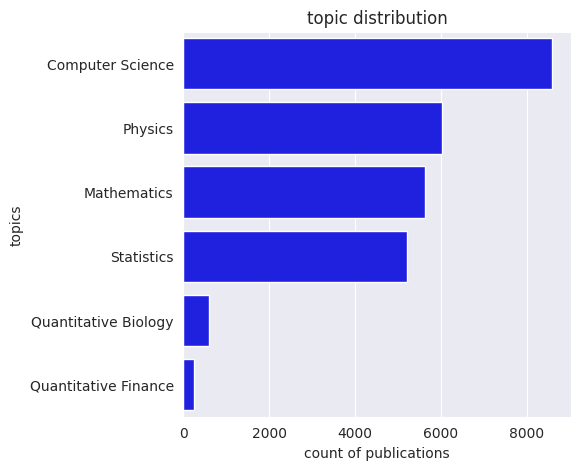

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.set_style("darkgrid")

ax = sns.barplot(x=totalCounts.values, y=totalCounts.index, color = 'blue')
ax.set_title("topic distribution")
ax.set_xlabel("count of publications")
ax.set_ylabel("topics")
plt.show()

## Processing text columns

### User-defined functions required

The following functions are defined in this notebook to process the text columns in the dataframe.
- `clean_sentence` - removes punctuations, special characters, additional spaces and any words with length < 3
- `textPrep` - funtion to remove multiple spaces, convert to lower case and lemmatize
- `processText` - removes stopwords and tokenizes words

**These functions are not necessary in this analysis**
- `getPandasLDA` - get corresponding model, corpus and list of unique indices, as this ties back to the original dataset
- `getPandasTopics` - generates pandas dataframe where the columns in the dataframe are list of terms in a particular topic with the corresponding probababilities and dominant topic. there is also an index column, required to map back to the original dataframe

In [ ]:
def clean_sentence(sentence):

  '''function to clean up the sentences
  this removes punctuations, special characters,
  numbers, additional spaces in between
  words and remove any words whose length < 3.'''

  #replace non-alpha characters with spaces
  sentence = re.sub(r"[^a-z A-Z]", " ", sentence)

  #replace any extra spaces
  sentence = re.sub(r"/s+", "", sentence)

  #only retain words of length >= 3
  sentence = " ".join([ele for ele in sentence.split() if len(ele) >= 3])

  return sentence

In [ ]:
def textPrep(sentence):

  '''funtion to remove multiple spaces, convert to lower case and lemmatize'''

  # convert to lower case
  sentence = sentence.lower()

  # remove multiple spaces
  sentence = ' '.join(sentence.split())

  # lemmatize
  lemmatizer = WordNetLemmatizer()
  words = ' '.join(lemmatizer.lemmatize(word) for word in sentence.split())

  return words

In [ ]:
def processText(sentence):

  '''function to remove stopwords from text
  and tokenize'''

  tokens = word_tokenize(sentence)
  tokens = [token for token in tokens if token not in stopWords]
  return tokens

In [ ]:
# def getPandasLDA(dfpd):

#   '''function to get LDA model, corpus and list of unique indices'''

#   index = [idx for idx in dfpd["ID"]]

#   # create dictionary
#   id2word = Dictionary(dfpd["words"].tolist())

#   # create corpus
#   texts = dfpd["words"].tolist()

#   # term document frequency
#   corpus = [id2word.doc2bow(text) for text in texts]

#   # build lda model
#   numTopics = 5
#   ldaModel = LdaModel(corpus = corpus,
#                       id2word = id2word,
#                       num_topics = numTopics,
#                       random_state = 12,
#                       update_every = 1,
#                       chunksize=50,
#                       passes = 10,
#                       alpha = "auto",
#                       per_word_topics = True)
#   return ldaModel, corpus, index

In [ ]:
# def getPandasTopics(dfpd):

#   '''function to generate pandas dataframe
#   here the columns in the dataframe are list
#   of terms in a particular topic with the
#   corresponding probababilities and dominant topic.
#   there is also an index column, required to map
#   back to the original dataframe'''

#   model, corpus, index = getPandasLDA(dfpd)

#   topicsDF = pd.DataFrame()

#   # get main topic in each document
#   for i, row in enumerate(model[corpus]):
#     row = sorted(row[0], key = lambda x: (x[1]), reverse = True)

#     # get dominant topic, key terms for each document
#     for j , (topic_num, perc_topic) in enumerate(row):
#       if j == 0:   # dominant topic
#         wp = model.show_topic(topic_num)
#         terms = [word for word, prob in wp]
#         weights = [prob for word, prob in wp]
#         topicsDF = topicsDF.append(pd.Series([int(topic_num + 1), \
#                                               terms, weights]), \
#                                               ignore_index = True)
#       else:
#         break

#   topicsDF.columns = ["Topic", "TopicTerms", "TermProb"]
#   topicsDF["Index"] = index

#   return topicsDF

### Combine text columns
The two columns containing text are combined into one and create a new column `Text` which will be the inpiut for all the text processing, text clean-up and eventually the topic modeling. Retain only the text columns as the rest are not required for topic modeling

In [ ]:
pandasDF["Text"] = pandasDF["TITLE"] + " " + pandasDF["ABSTRACT"]
pandasDF = pandasDF[["ID", "TITLE", "ABSTRACT", "Text"]]
pandasDF.head()

,ID,TITLE,ABSTRACT,Text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,Reconstructing Subject-Specific Effect Maps ...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,Rotation Invariance Neural Network Rotation ...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,Spherical polyharmonics and Poisson kernels fo...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,A finite element approximation for the stochas...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,Comparative study of Discrete Wavelet Transfor...


In [ ]:
# apply the above function to clean up text and create a new column
# the regexp_replace function applied below cleans up strings
# which have more than 2 same letters consecutively in a word

pandasDF.loc[:, "Text"] = pandasDF["Text"].apply(lambda x: clean_sentence(x))

In [ ]:
pandasDF["Text"].head()

0    Reconstructing Subject Specific Effect Maps Pr...
1    Rotation Invariance Neural Network Rotation in...
2    Spherical polyharmonics and Poisson kernels fo...
3    finite element approximation for the stochasti...
4    Comparative study Discrete Wavelet Transforms ...
Name: Text, dtype: object

Prepare the Text column for topic modeling
- remove multiple spaces
- convert to lower case
- lemmatize
- transform documents into counts

In [ ]:
pandasDF.loc[:, "Text"] = pandasDF["Text"].apply(lambda x: textPrep(x))

# transform documents into counts

vect = TfidfVectorizer(max_features = 50000, stop_words = "english")
dtm = vect.fit_transform(pandasDF["Text"])
dtm.shape

(20972, 45674)

## Topic Modeling
Start with identifying the topics and showing wordcloud of the topic modeling

In [ ]:
lda = LatentDirichletAllocation(n_components = 5, random_state = 8)

In [ ]:
lda.fit_transform(dtm)

array([[0.02215998, 0.02183401, 0.02263089, 0.91154053, 0.02183459],
       [0.03752859, 0.03628024, 0.03749839, 0.8524124 , 0.03628038],
       [0.03956497, 0.14154469, 0.74170868, 0.03887925, 0.03830241],
       ...,
       [0.02753003, 0.0270326 , 0.02770659, 0.89069656, 0.02703422],
       [0.0278881 , 0.02527673, 0.89403031, 0.02752785, 0.025277  ],
       [0.03488419, 0.03466504, 0.72124621, 0.17453697, 0.03466759]])

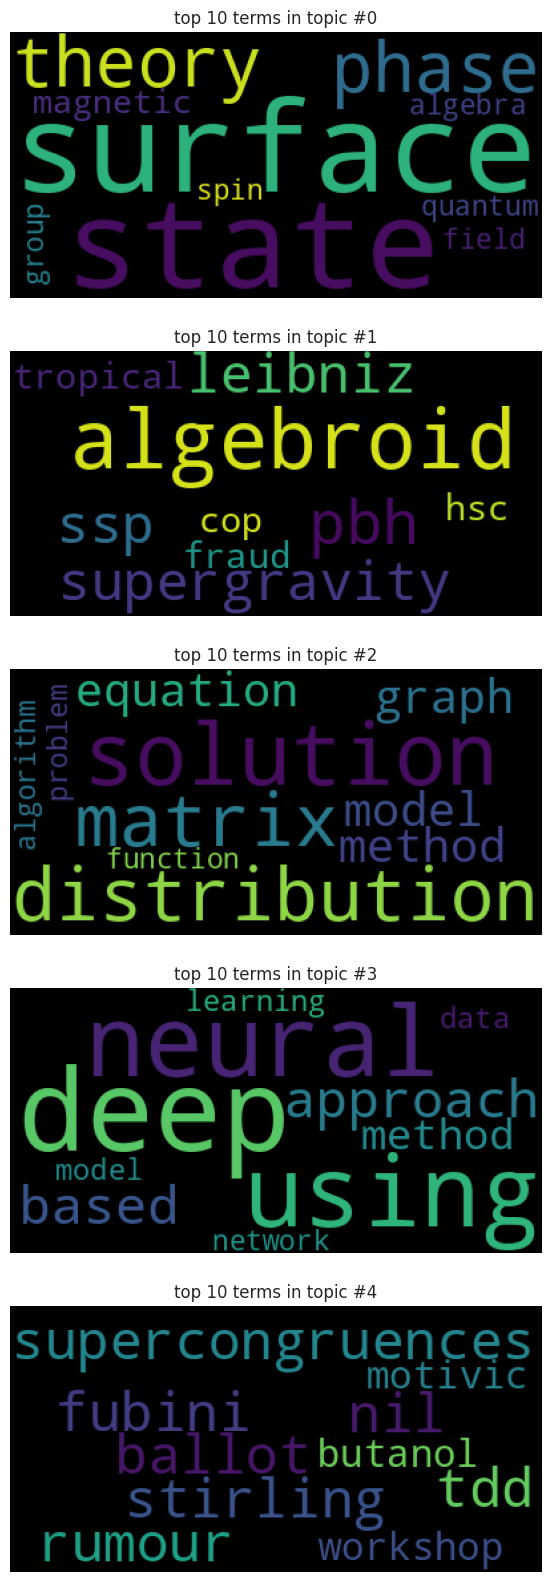

In [ ]:
# wordcloud representation

fig, ax = plt.subplots(5, 1, figsize = (30, 20))

for idx, topic in enumerate(lda.components_):
  terms = [vect.get_feature_names_out()[i] \
           for i in topic.argsort()[-10:]]

  wordcloud = WordCloud().generate(' '.join(terms))

  ax[idx].imshow(wordcloud)
  ax[idx].set_title(f"top 10 terms in topic #{idx}")
  ax[idx].axis("off")

### Another way to do topic modeling

In [ ]:
stopWords = set(stopwords.words("english"))

textFinal = [processText(x) for x in pandasDF["Text"]]

In [ ]:
# create a dictionary and a corpus

dictionary = Dictionary(textFinal)

# filter out some terms that appear in < 2 or in all documents - refinement
dictionary.filter_extremes(no_below = 2, no_above = 1)

# build corpus
corpus = [dictionary.doc2bow(word) for word in textFinal]

In [ ]:
# build lda model
numTopics = 5
ldaModel = LdaModel(corpus = corpus,
                    id2word = dictionary,
                    num_topics = numTopics,
                    random_state = 12,
                    update_every = 1,
                    chunksize=50,
                    passes = 10,
                    alpha = "auto",
                    per_word_topics = True)


In [ ]:
# print topics and top terms in each topic

for topic in ldaModel.show_topics(numTopics):
  print("Topic:", topic[0])
  print("Top terms:", topic[1], "\n")

Topic: 0
Top terms: 0.010*"system" + 0.008*"time" + 0.007*"based" + 0.007*"paper" + 0.006*"data" + 0.006*"network" + 0.005*"algorithm" + 0.005*"control" + 0.005*"approach" + 0.005*"using" 

Topic: 1
Top terms: 0.026*"model" + 0.024*"network" + 0.022*"data" + 0.020*"method" + 0.019*"learning" + 0.010*"approach" + 0.009*"neural" + 0.008*"based" + 0.008*"deep" + 0.008*"using" 

Topic: 2
Top terms: 0.012*"time" + 0.012*"model" + 0.010*"two" + 0.010*"number" + 0.009*"system" + 0.009*"equation" + 0.009*"graph" + 0.008*"order" + 0.007*"structure" + 0.007*"one" 

Topic: 3
Top terms: 0.019*"problem" + 0.013*"function" + 0.011*"group" + 0.010*"algorithm" + 0.010*"space" + 0.009*"matrix" + 0.008*"class" + 0.008*"bound" + 0.008*"result" + 0.008*"set" 

Topic: 4
Top terms: 0.009*"energy" + 0.008*"field" + 0.008*"phase" + 0.007*"mass" + 0.007*"high" + 0.006*"particle" + 0.006*"low" + 0.006*"temperature" + 0.006*"magnetic" + 0.005*"wave" 



## Visualization

Use `pyLDAvis` module for in notebook visualization

In [ ]:
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [ ]:
vis = gensimvis.prepare(ldaModel, corpus, dictionary)
pyLDAvis.display(vis)